# AIN429 Data Mining Lab
## Assignment 4 : Classification
#### Student Number: 21992919
##### Student Name/Surname : Melike Nur DULKADİR

Importing necessary libraries and after then starting the project.

In [51]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pylab as pl
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
import plotly.express as px
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("data.csv")

In [3]:
df.head()

Class  User         X0         Y0         Z0         X1         Y1  \
0      0     0   0.000000   0.000000   0.000000   0.000000   0.000000   
1      1     0  54.263880  71.466776 -64.807709  76.895635  42.462500   
2      1     0  56.527558  72.266609 -61.935252  39.135978  82.538530   
3      1     0  55.849928  72.469064 -62.562788  37.988804  82.631347   
4      1     0  55.329647  71.707275 -63.688956  36.561863  81.868749   

          Z1         X2         Y2  ...  Z8 X9 Y9 Z9 X10 Y10 Z10 X11 Y11 Z11  
0   0.000000   0.000000   0.000000  ...   0  0  0  0   0   0   0   0   0   0  
1 -72.780545  36.621229  81.680557  ...   ?  ?  ?  ?   ?   ?   ?   ?   ?   ?  
2 -49.596509  79.223743  43.254091  ...   ?  ?  ?  ?   ?   ?   ?   ?   ?   ?  
3 -50.606259  78.451526  43.567403  ...   ?  ?  ?  ?   ?   ?   ?   ?   ?   ?  
4 -52.752784  86.320630  68.214645  ...   ?  ?  ?  ?   ?   ?   ?   ?   ?   ?  

[5 rows x 38 columns]

# Analyzing the dataset

The check_df function is used to examine the dataset in a general way.

In [4]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)
    print("##################### Properties #####################")
    print(df.describe())


The following functions are used to detect and handle outliers.

In [5]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def replace_with_thresholds(dataframe, variable, q1=0.25, q3=0.75):
    low_limit, up_limit = outlier_thresholds(dataframe, variable, q1, q3)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


def check_outlier(dataframe, col_name, q1=.25, q3=.75):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1, q3)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

This function detect and return the numerical, categorical and cardinal variables in the dataset.

In [6]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """
    Returns the names of categorical, numeric and categorical but cardinal variables in the data set.
    Note: Categorical variables with numerical appearance are also included in categorical variables.

    Parameters
    ------
        dataframe: dataframe
                The dataframe from which variable names are to be retrieved
        cat_th: int, optional
                Class threshold for numeric but categorical variables
        car_th: int, optinal
                Class threshold for categorical but cardinal variables

    Returns
    ------
        cat_cols: list
                Categorical variable list
        num_cols: list
                Numeric variable list
        cat_but_car: list
                Categorical view cardinal variable list

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = total number of variables
        num_but_cat inside cat_cols.
        The sum of the 3 returned lists equals the total number of variables: cat_cols + num_cols + cat_but_car = number of variables
    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    #num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th anddataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    #cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    #num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    # print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

This function helps to create multiple boxplots for multiple columns.

In [7]:
def boxplot(df, num_cols):
    fig = plt.figure(figsize=(40,40))

    ax = fig.add_subplot(5,5,3)
    sns.boxplot(data=df[num_cols], ax=ax)

    fig.tight_layout()

Let's take a look at the general information about the dataset using the check_df function.

In [8]:
check_df(df)

##################### Shape #####################
(78096, 38)
##################### Types #####################
Class      int64
User       int64
X0       float64
Y0       float64
Z0       float64
X1       float64
Y1       float64
Z1       float64
X2       float64
Y2       float64
Z2       float64
X3        object
Y3        object
Z3        object
X4        object
Y4        object
Z4        object
X5        object
Y5        object
Z5        object
X6        object
Y6        object
Z6        object
X7        object
Y7        object
Z7        object
X8        object
Y8        object
Z8        object
X9        object
Y9        object
Z9        object
X10       object
Y10       object
Z10       object
X11       object
Y11       object
Z11       object
dtype: object
##################### NA #####################
Class    0
User     0
X0       0
Y0       0
Z0       0
X1       0
Y1       0
Z1       0
X2       0
Y2       0
Z2       0
X3       0
Y3       0
Z3       0
X4       0
Y4       0
Z4   

Missing value does not appear. However, question marks are missing values in the dataset.

In [9]:
df.corr()

Class      User        X0        Y0        Z0        X1        Y1  \
Class  1.000000 -0.030667  0.080209  0.081808  0.051832 -0.010528  0.144135   
User  -0.030667  1.000000 -0.013723  0.070217  0.192016 -0.042628  0.041793   
X0     0.080209 -0.013723  1.000000 -0.285254 -0.236433  0.124124 -0.009039   
Y0     0.081808  0.070217 -0.285254  1.000000  0.550998 -0.001266  0.133322   
Z0     0.051832  0.192016 -0.236433  0.550998  1.000000  0.014794  0.209590   
X1    -0.010528 -0.042628  0.124124 -0.001266  0.014794  1.000000 -0.293786   
Y1     0.144135  0.041793 -0.009039  0.133322  0.209590 -0.293786  1.000000   
Z1     0.089894  0.183271  0.033096  0.225545  0.464174 -0.261213  0.572763   
X2    -0.052351 -0.059501  0.106164  0.005438  0.008743  0.139548 -0.027720   
Y2     0.169296  0.001024 -0.012656  0.082158  0.149581 -0.050947  0.108076   
Z2     0.095512  0.155586  0.023483  0.187781  0.420451 -0.012322  0.184162   

             Z1        X2        Y2        Z2  
Class  0.089894 -0.052351  0.169296  0.095512  
User   0.183271 -0.059501  0.001024  0.155586  
X0     0.033096  0.106164 -0.012656  0.023483  
Y0     0.225545  0.005438  0.082158  0.187781  
Z0     0.464174  0.008743  0.149581  0.420451  
X1    -0.261213  0.139548 -0.050947 -0.012322  
Y1     0.572763 -0.027720  0.108076  0.184162  
Z1     1.000000 -0.009244  0.175152  0.455485  
X2    -0.009244  1.000000 -0.316701 -0.299826  
Y2     0.175152 -0.316701  1.000000  0.587785  
Z2     0.455485 -0.299826  0.587785  1.000000

Examining the counts of the classes.

In [10]:
df["Class"].value_counts()

3    16344
1    16265
5    15733
2    14978
4    14775
0        1
Name: Class, dtype: int64

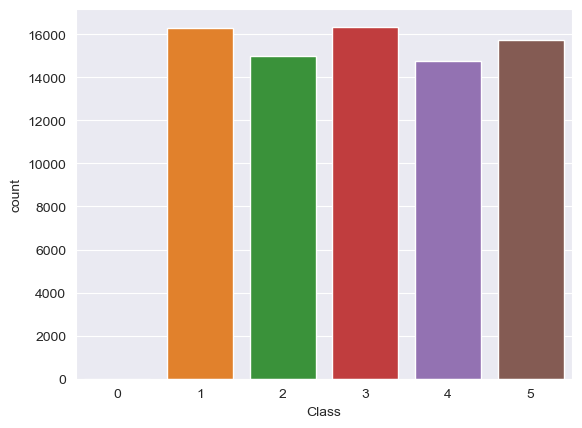

In [11]:
sns.countplot(x = df['Class'],label="Count")
plt.show()

For a more understandable use, we move the Class column, which contains output classes, to the end.

In [12]:
df['Class'] = df.pop('Class')

<AxesSubplot: title={'center': 'Corelation Between Features'}>

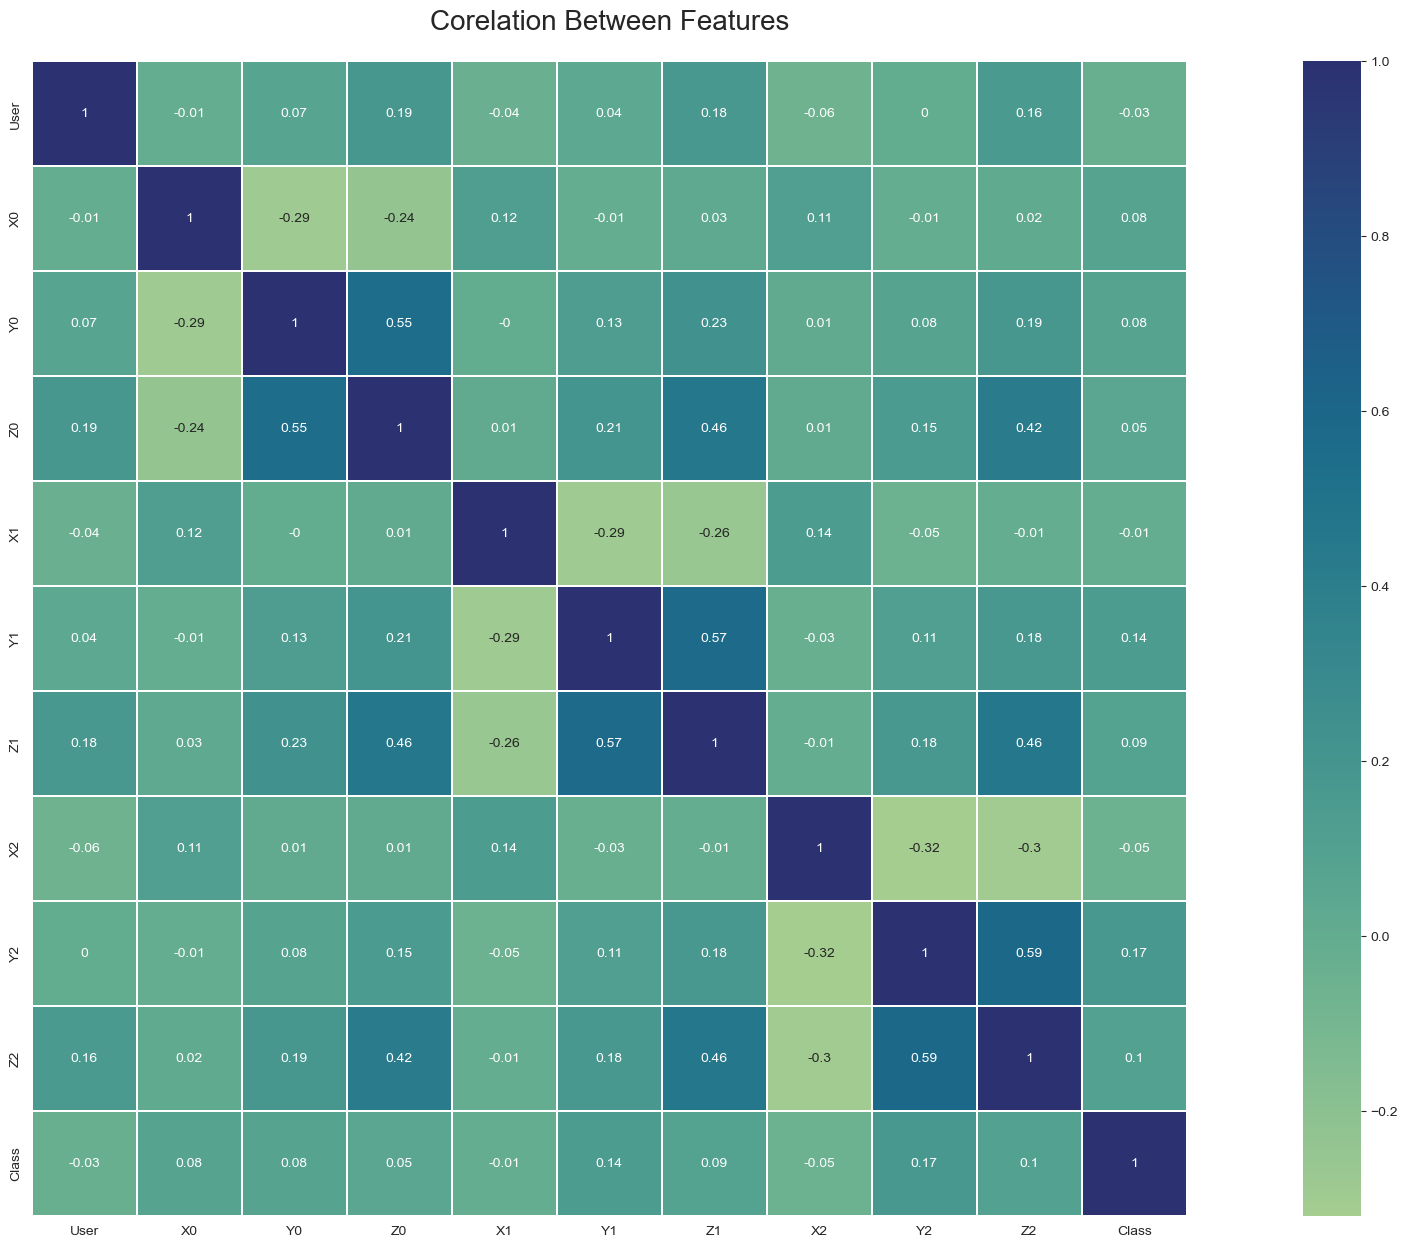

In [13]:
corelation = plt.cm.viridis
plt.figure(figsize=(30,15))
plt.title('Corelation Between Features', y=1.02, size=20)

sns.heatmap(data=df.corr().round(2), linewidths=0.2, vmax=1, square=True, annot=True, cmap="crest", linecolor='white')

Plotting pairwise relationships in the dataset.

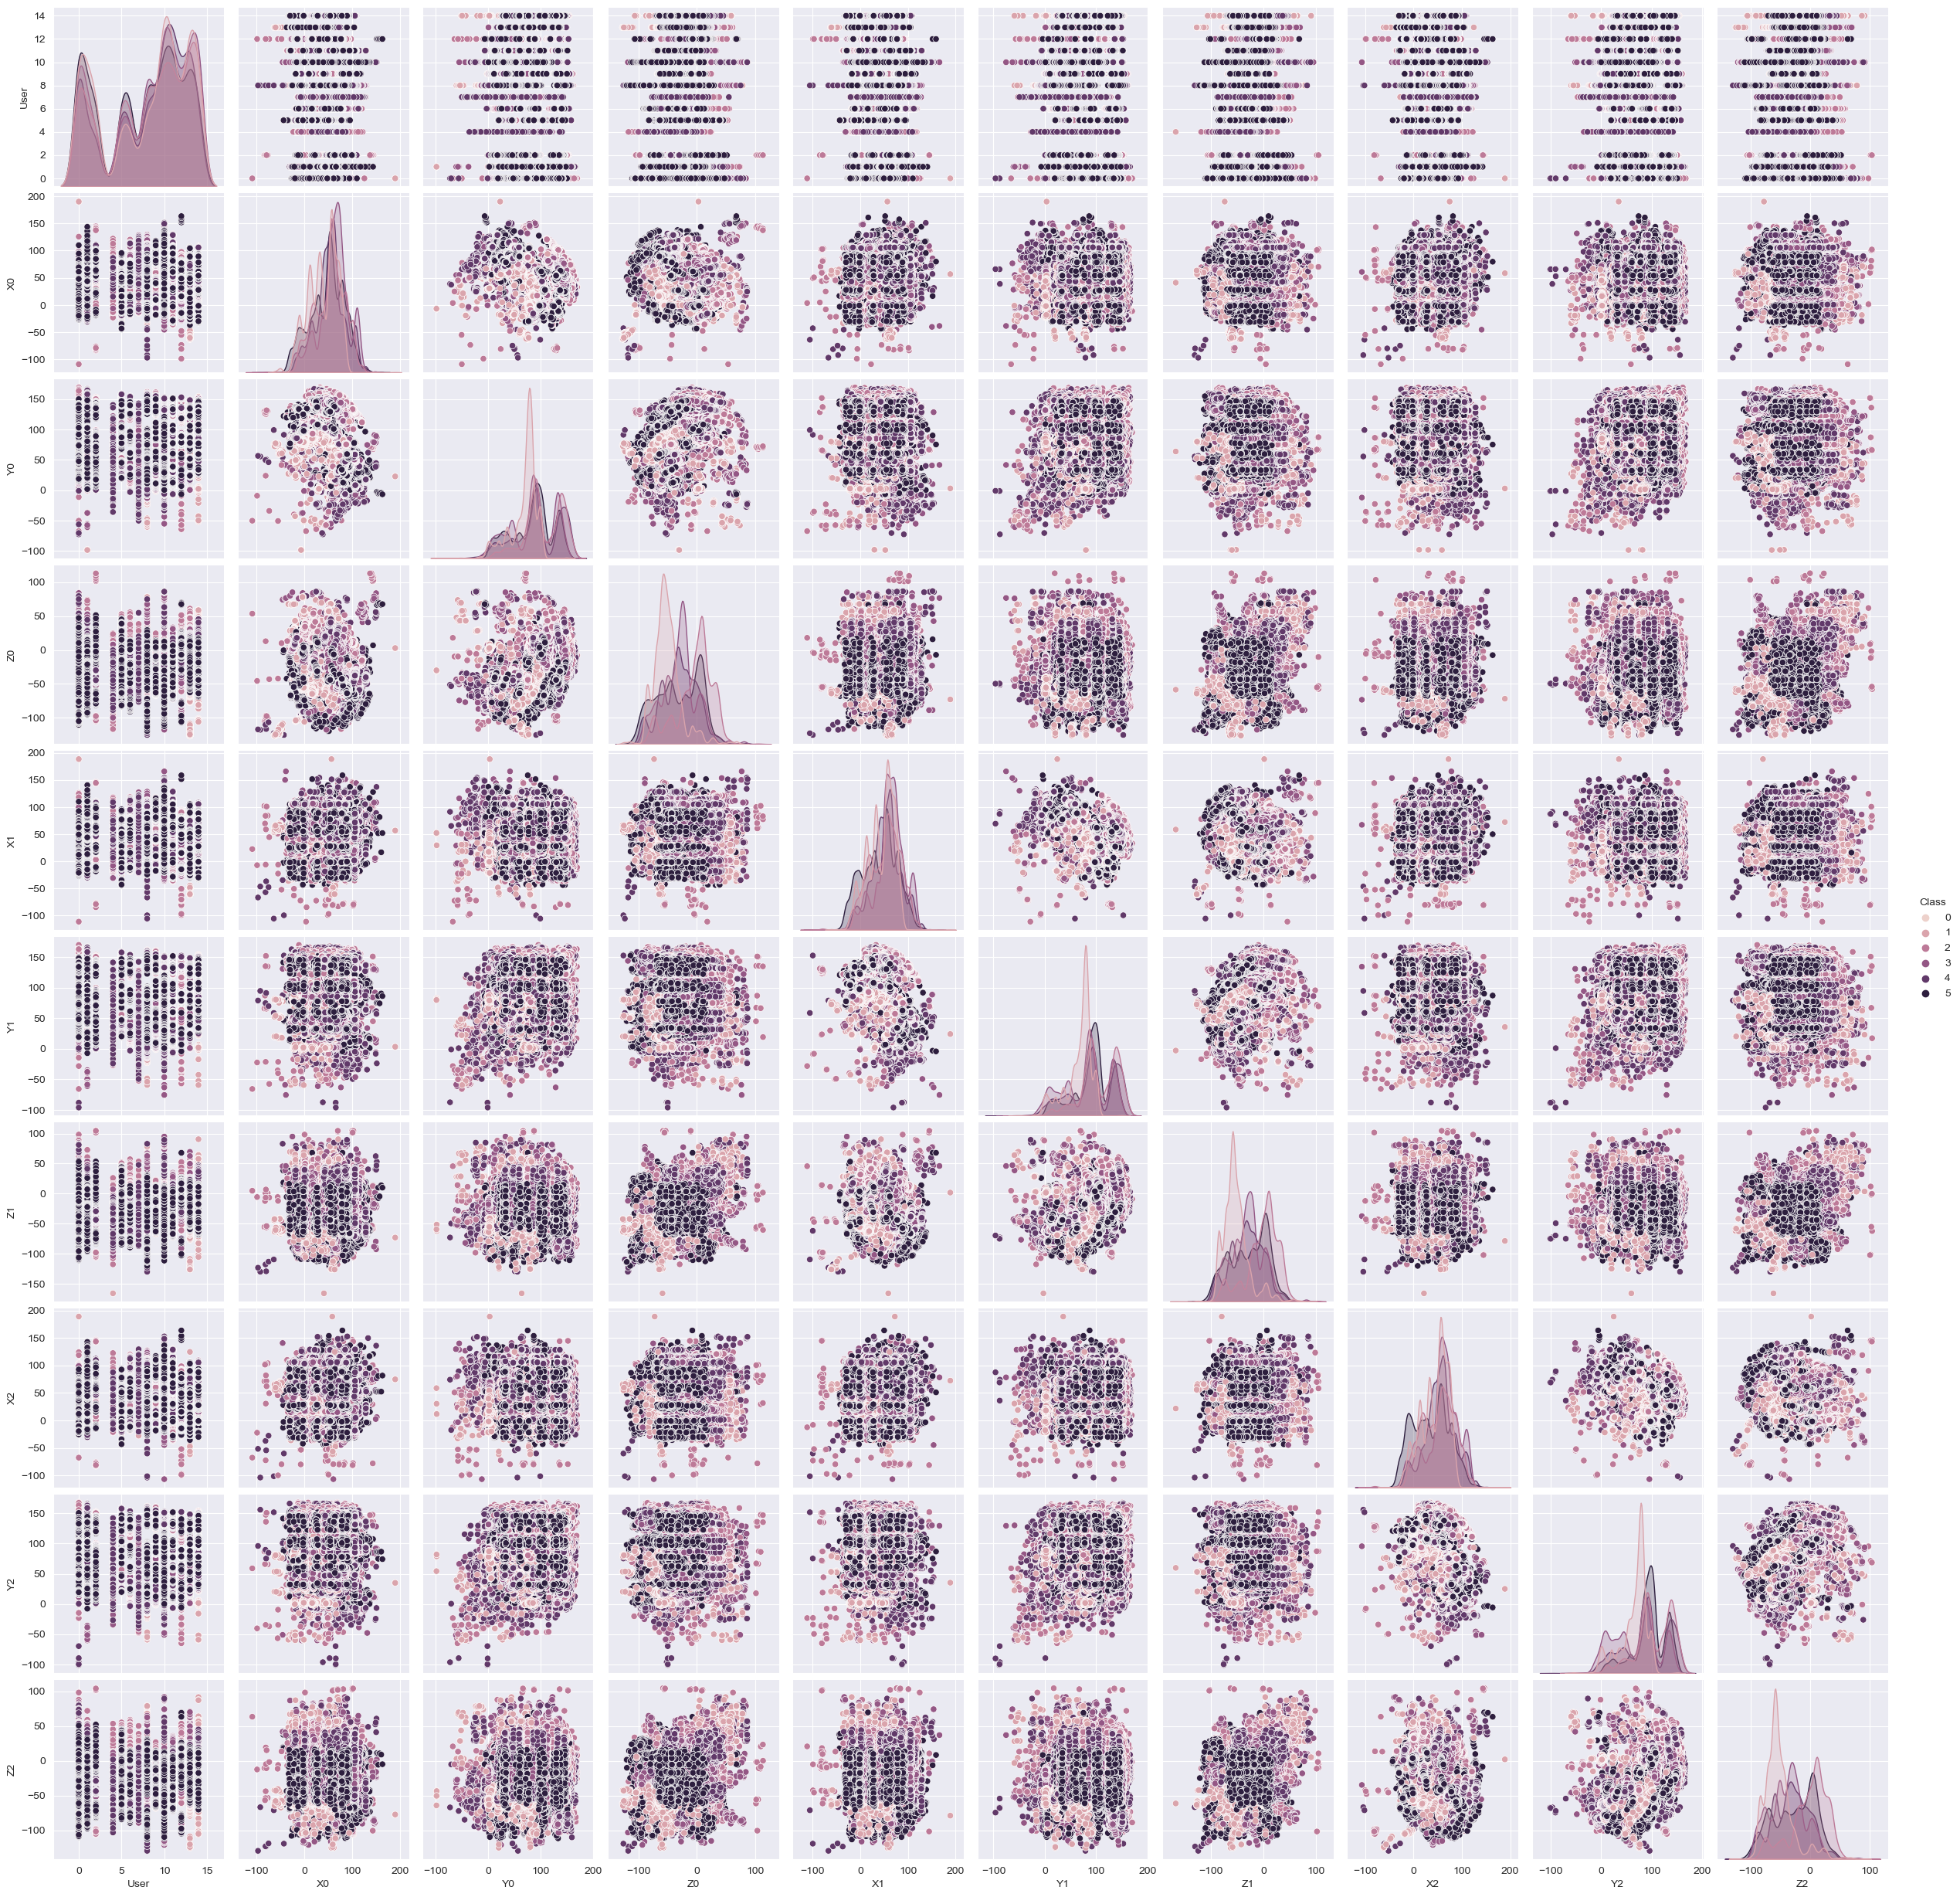

In [22]:
sns.pairplot(data=df[df.columns], hue = 'Class')

# Preprocessing

## Handling Missing Values

In [14]:
for col in df.columns:
    print(col)
    print((df[col] == '?').sum())

User
0
X0
0
Y0
0
Z0
0
X1
0
Y1
0
Z1
0
X2
0
Y2
0
Z2
0
X3
690
Y3
690
Z3
690
X4
3120
Y4
3120
Z4
3120
X5
13023
Y5
13023
Z5
13023
X6
25848
Y6
25848
Z6
25848
X7
39152
Y7
39152
Z7
39152
X8
47532
Y8
47532
Z8
47532
X9
54128
Y9
54128
Z9
54128
X10
63343
Y10
63343
Z10
63343
X11
78064
Y11
78064
Z11
78064
Class
0


It will not be correct to use these columns because some columns have too many missing values. For this reason, we continue by dropping many columns and the User column that does not inform us.

In [15]:
df.shape

(78096, 38)

In this columns there is so many missing values. So dropping this columns will be more effective.

In [16]:
df.drop(["User","X11","Y11","Z11","X10","Y10","Z10","X9","Y9","Z9","X8","Y8","Z8","X7","Y7","Z7","X6","Y6","Z6","X5","Y5","Z5"],axis=1,inplace=True)

In [17]:
df.shape

(78096, 16)

In [18]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 78096
Variables: 16
cat_cols: 0
num_cols: 10
cat_but_car: 6


Although some columns contain numeric values, they appear as object type. With the help of the grab_col_names function, we get these functions cardinally. Then, when we change its type, we observe that their ? is translated as missing value.

In [19]:
cat_but_car

['X3', 'Y3', 'Z3', 'X4', 'Y4', 'Z4']

In [20]:
for col in cat_but_car:
    df[col] = pd.to_numeric(df[col],errors = 'coerce')

As seen in the NA values part there is missing values. These missing values will be filled with the mean value of this column.

In [21]:
check_df(df)

##################### Shape #####################
(78096, 16)
##################### Types #####################
X0       float64
Y0       float64
Z0       float64
X1       float64
Y1       float64
Z1       float64
X2       float64
Y2       float64
Z2       float64
X3       float64
Y3       float64
Z3       float64
X4       float64
Y4       float64
Z4       float64
Class      int64
dtype: object
##################### NA #####################
X0          0
Y0          0
Z0          0
X1          0
Y1          0
Z1          0
X2          0
Y2          0
Z2          0
X3        690
Y3        690
Z3        690
X4       3120
Y4       3120
Z4       3120
Class       0
dtype: int64
##################### Quantiles #####################
             0.00       0.05       0.50        0.95        0.99        1.00
X0    -108.552738 -10.346013  54.619964  103.510646  115.080564  190.017835
Y0     -98.233756  11.626910  86.526246  147.367099  156.617310  169.175464
Z0    -126.770872 -85.621637 -30.864

In [22]:
for col in cat_but_car:
    df[col].fillna(value=df[col].mean(), inplace=True)

Now all feature's type is correct.

In [23]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 78096
Variables: 16
cat_cols: 0
num_cols: 16
cat_but_car: 0


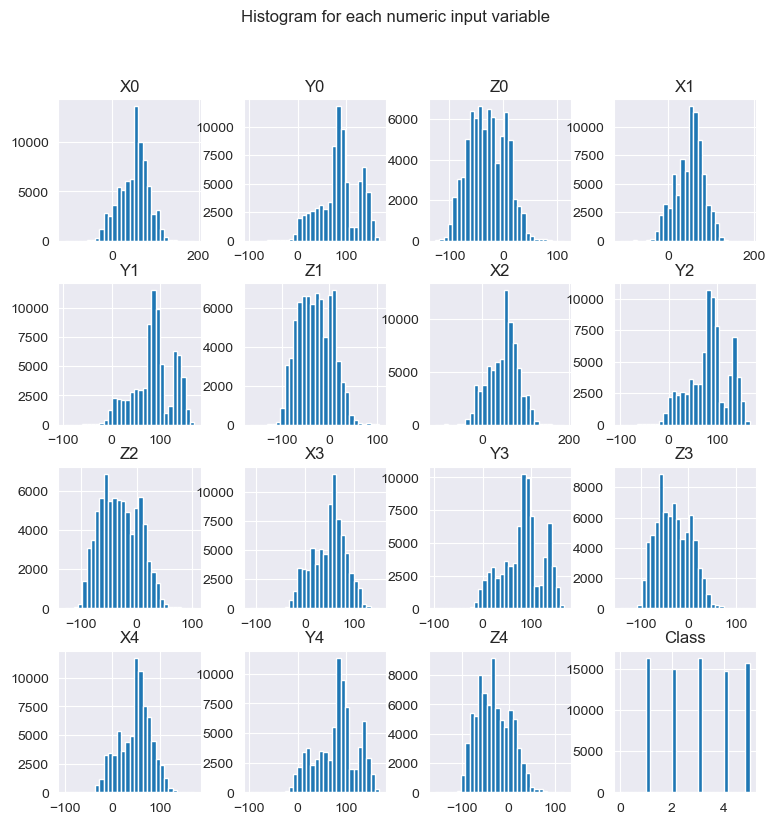

In [24]:
df[num_cols].hist(bins=30, figsize=(9,9))
pl.suptitle("Histogram for each numeric input variable")
plt.show()

In [25]:
num_cols.remove("Class")

## Outlier Analysis

In each column there are outlier values.

In [26]:
for col in num_cols:
    print(check_outlier(df,col))

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


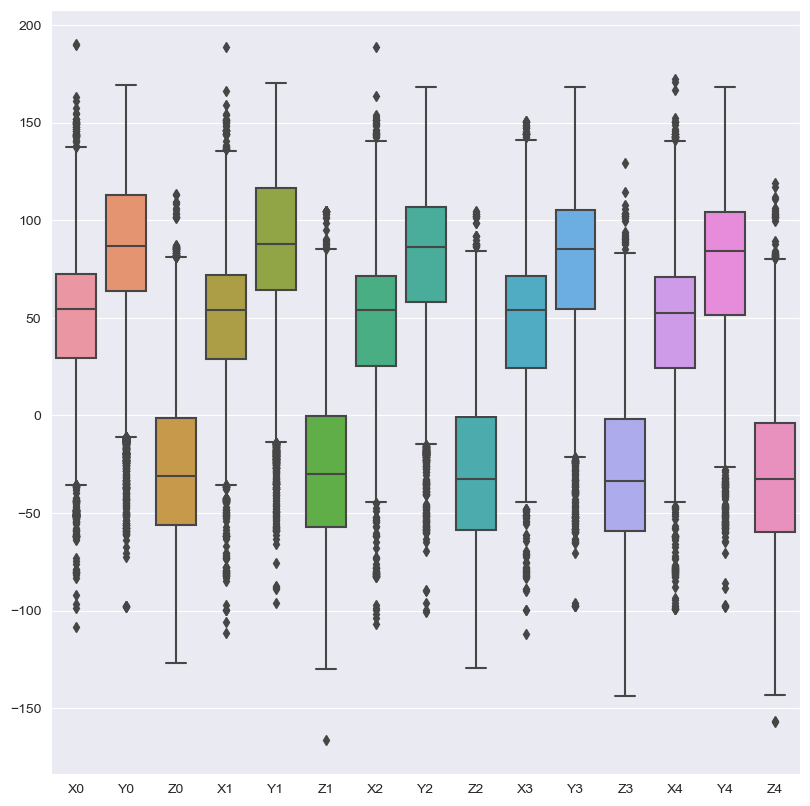

In [27]:
boxplot(df, num_cols)

Also Scaler should be applied.

In [28]:
for col in num_cols:
    replace_with_thresholds(df,col)

In [29]:
df.shape

(78096, 16)

In [30]:
for col in num_cols:
    print(check_outlier(df,col))

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


After StandardScaler applied and outliers handled following boxplots created.

In [31]:
scaler = StandardScaler()
scaler.fit(df[num_cols])
df[num_cols] = scaler.transform(df[num_cols])

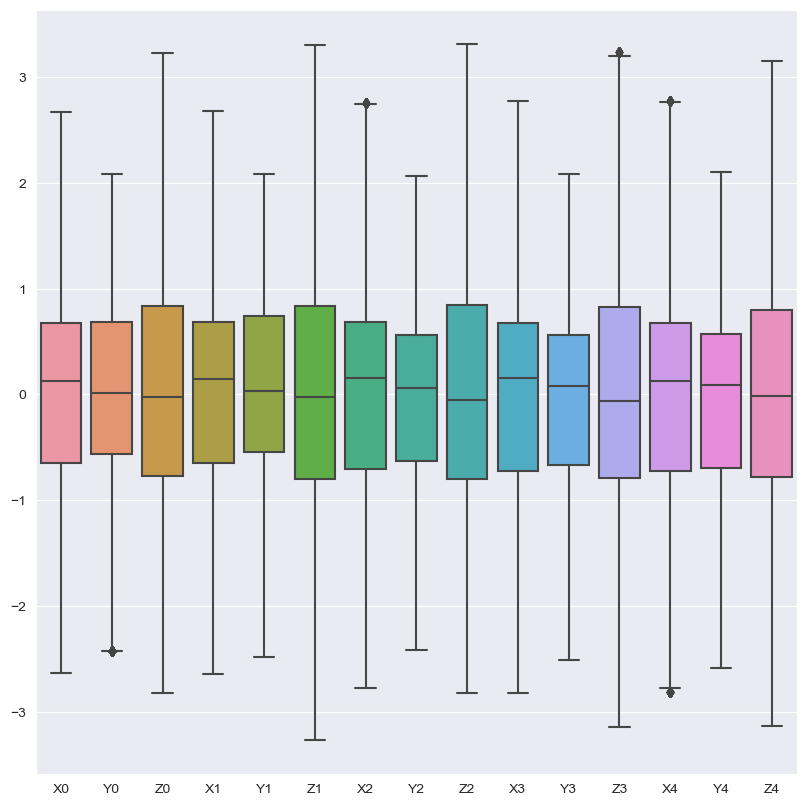

In [32]:
boxplot(df, num_cols)

No outlier and all features in the same scale.

## Building Models

### Classification

Classification is a supervised machine learning process that involves predicting the class of given data points. Those classes can be targets, labels or categories. In classification, a program uses the dataset or observations provided to learn how to categorize new observations into various classes or groups. For instance, 0 or 1, red or blue, yes or no, spam or not spam, etc. Targets, labels, or categories can all be used to describe classes.

Classification Algorithms can be further divided into the mainly two category:

1.  Linear Models
    1.  Logistic Regression
    2.  Support Vector Machines

2.  Non-linear Models
    1.  K-Nearest Neighbors
    2.  Kernel SVM
    3.  Naïve Bayes
    4.  Decision Tree Classification
    5.  Random Forest Classification

### Types of Classification in Machine Learning

1. **Lazy Learners Lazy learners** store the training data and wait until testing data appears. When it does, classification is conducted based on the most related stored training data. Compared to eager learners, lazy learners spend less training time but more time in predicting. Examples: K-nearest neighbor and case-based reasoning.

2. **Eager Learners Eager learners** construct a classification model based on the given training data before receiving data for classification. It must be able to commit to a single hypothesis that covers the entire instance space. Because of this, eager learners take a long time for training and less time for predicting. Examples: Decision tree, naive Bayes and artificial neural networks.

We start by shuffling our dataset.

In [33]:
df = shuffle(df)

Then we separate the features and outputs as X and y and create train and test data.

In [34]:
X = df[num_cols]
y = df.Class

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0)

## Logistic Regression

It is a linear classification algorithm in machine learning that uses one or more independent variables to determine an outcome. The outcome is measured with a dichotomous variable meaning it will have only two possible outcomes. However, we can apply binary transformation approaches such as one-versus-one and one-versus-all to adapt logistic regression algorithm for multi-class classification tasks.


In [36]:
logistic_regression_model = LogisticRegression()
logistic_regression_model.fit(X_train, y_train)
logistic_regression_predictions = logistic_regression_model.predict(X_test)
print('Accuracy of Logistic regression classifier on training set: {:.2f}'
      .format(logistic_regression_model.score(X_train, y_train)))
print('Accuracy of Logistic regression classifier on test set: {:.2f}'
      .format(logistic_regression_model.score(X_test, y_test)))

Accuracy of Logistic regression classifier on training set: 0.62
Accuracy of Logistic regression classifier on test set: 0.62


In [37]:
print(classification_report(y_test,logistic_regression_predictions))

              precision    recall  f1-score   support

           1       0.77      0.80      0.78      3250
           2       0.68      0.73      0.70      3056
           3       0.61      0.65      0.63      3206
           4       0.48      0.38      0.42      2935
           5       0.54      0.53      0.54      3173

    accuracy                           0.62     15620
   macro avg       0.61      0.62      0.61     15620
weighted avg       0.62      0.62      0.62     15620



In [38]:
print(confusion_matrix(y_test,logistic_regression_predictions))

[[2611   27  229  100  283]
 [  30 2242  216  226  342]
 [ 211  141 2078  475  301]
 [ 230  511  548 1109  537]
 [ 328  384  345  420 1696]]


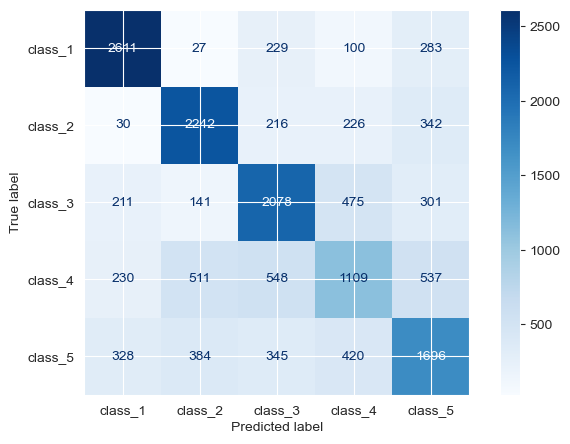

In [68]:
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(confusion_matrix(y_test, logistic_regression_predictions),display_labels=["class_1", "class_2", "class_3","class_4","class_5"])
cmp.plot(ax=ax,cmap=plt.cm.Blues)

Although outlier and missing values were cleared by preproccesing, the logistic regression model performed poorly on this dataset. This is because the target tag does not have a linear correlation with the features. Logistic regression (or linear regression models for regression problems does not work well in such cases, even with train data).

## Decision Tree Classifier

The decision tree algorithm builds the classification model in the form of a tree structure. It utilizes the if-then rules which are equally exhaustive and mutually exclusive in classification. The process goes on with breaking down the data into smaller structures and eventually associating it with an incremental decision tree. The final structure looks like a tree with nodes and leaves. The rules are learned sequentially using the training data one at a time. Each time a rule is learned, the tuples covering the rules are removed. The process continues on the training set until the termination point is met.

It is an eager learning and non-linear classification algorithm.

In [70]:
decision_tree_model = DecisionTreeClassifier().fit(X_train, y_train)
decision_tree_predictions = decision_tree_model.predict(X_test)
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
      .format(decision_tree_model.score(X_train, y_train)))
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
      .format(decision_tree_model.score(X_test, y_test)))

Accuracy of Decision Tree classifier on training set: 1.00
Accuracy of Decision Tree classifier on test set: 0.92


In [72]:
print(classification_report(y_test,decision_tree_predictions))

              precision    recall  f1-score   support

           1       0.98      0.98      0.98      3250
           2       0.90      0.90      0.90      3056
           3       0.91      0.92      0.92      3206
           4       0.89      0.90      0.89      2935
           5       0.92      0.90      0.91      3173

    accuracy                           0.92     15620
   macro avg       0.92      0.92      0.92     15620
weighted avg       0.92      0.92      0.92     15620



Since the Decision tree is a non-linear algorithm, the accuracy obtained with this model is very high. Since it creates the tree according to the train data, 100 percent success in the train set is expected. However, it would be good to determine the maximum depth in the model to prevent overfitting.

In [84]:
print(confusion_matrix(y_test,decision_tree_predictions))

[[3183   13   20   16   18]
 [  15 2749   55  112  125]
 [  25   47 2950  125   59]
 [  21   92  135 2630   57]
 [  17  159   70   75 2852]]


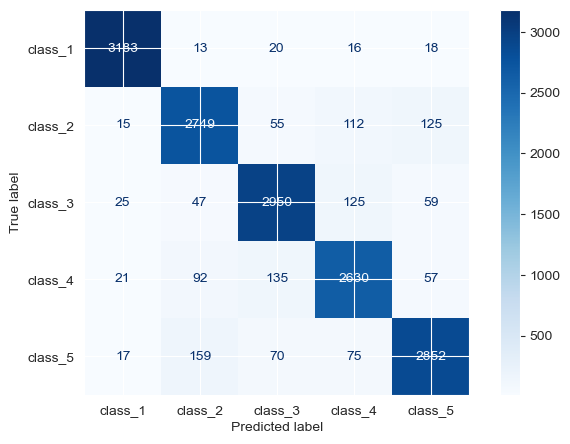

In [73]:
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(confusion_matrix(y_test, decision_tree_predictions),display_labels=["class_1", "class_2", "class_3","class_4","class_5"])
cmp.plot(ax=ax,cmap=plt.cm.Blues)

In [53]:
decision_tree_model.classes_

array([0, 1, 2, 3, 4, 5], dtype=int64)

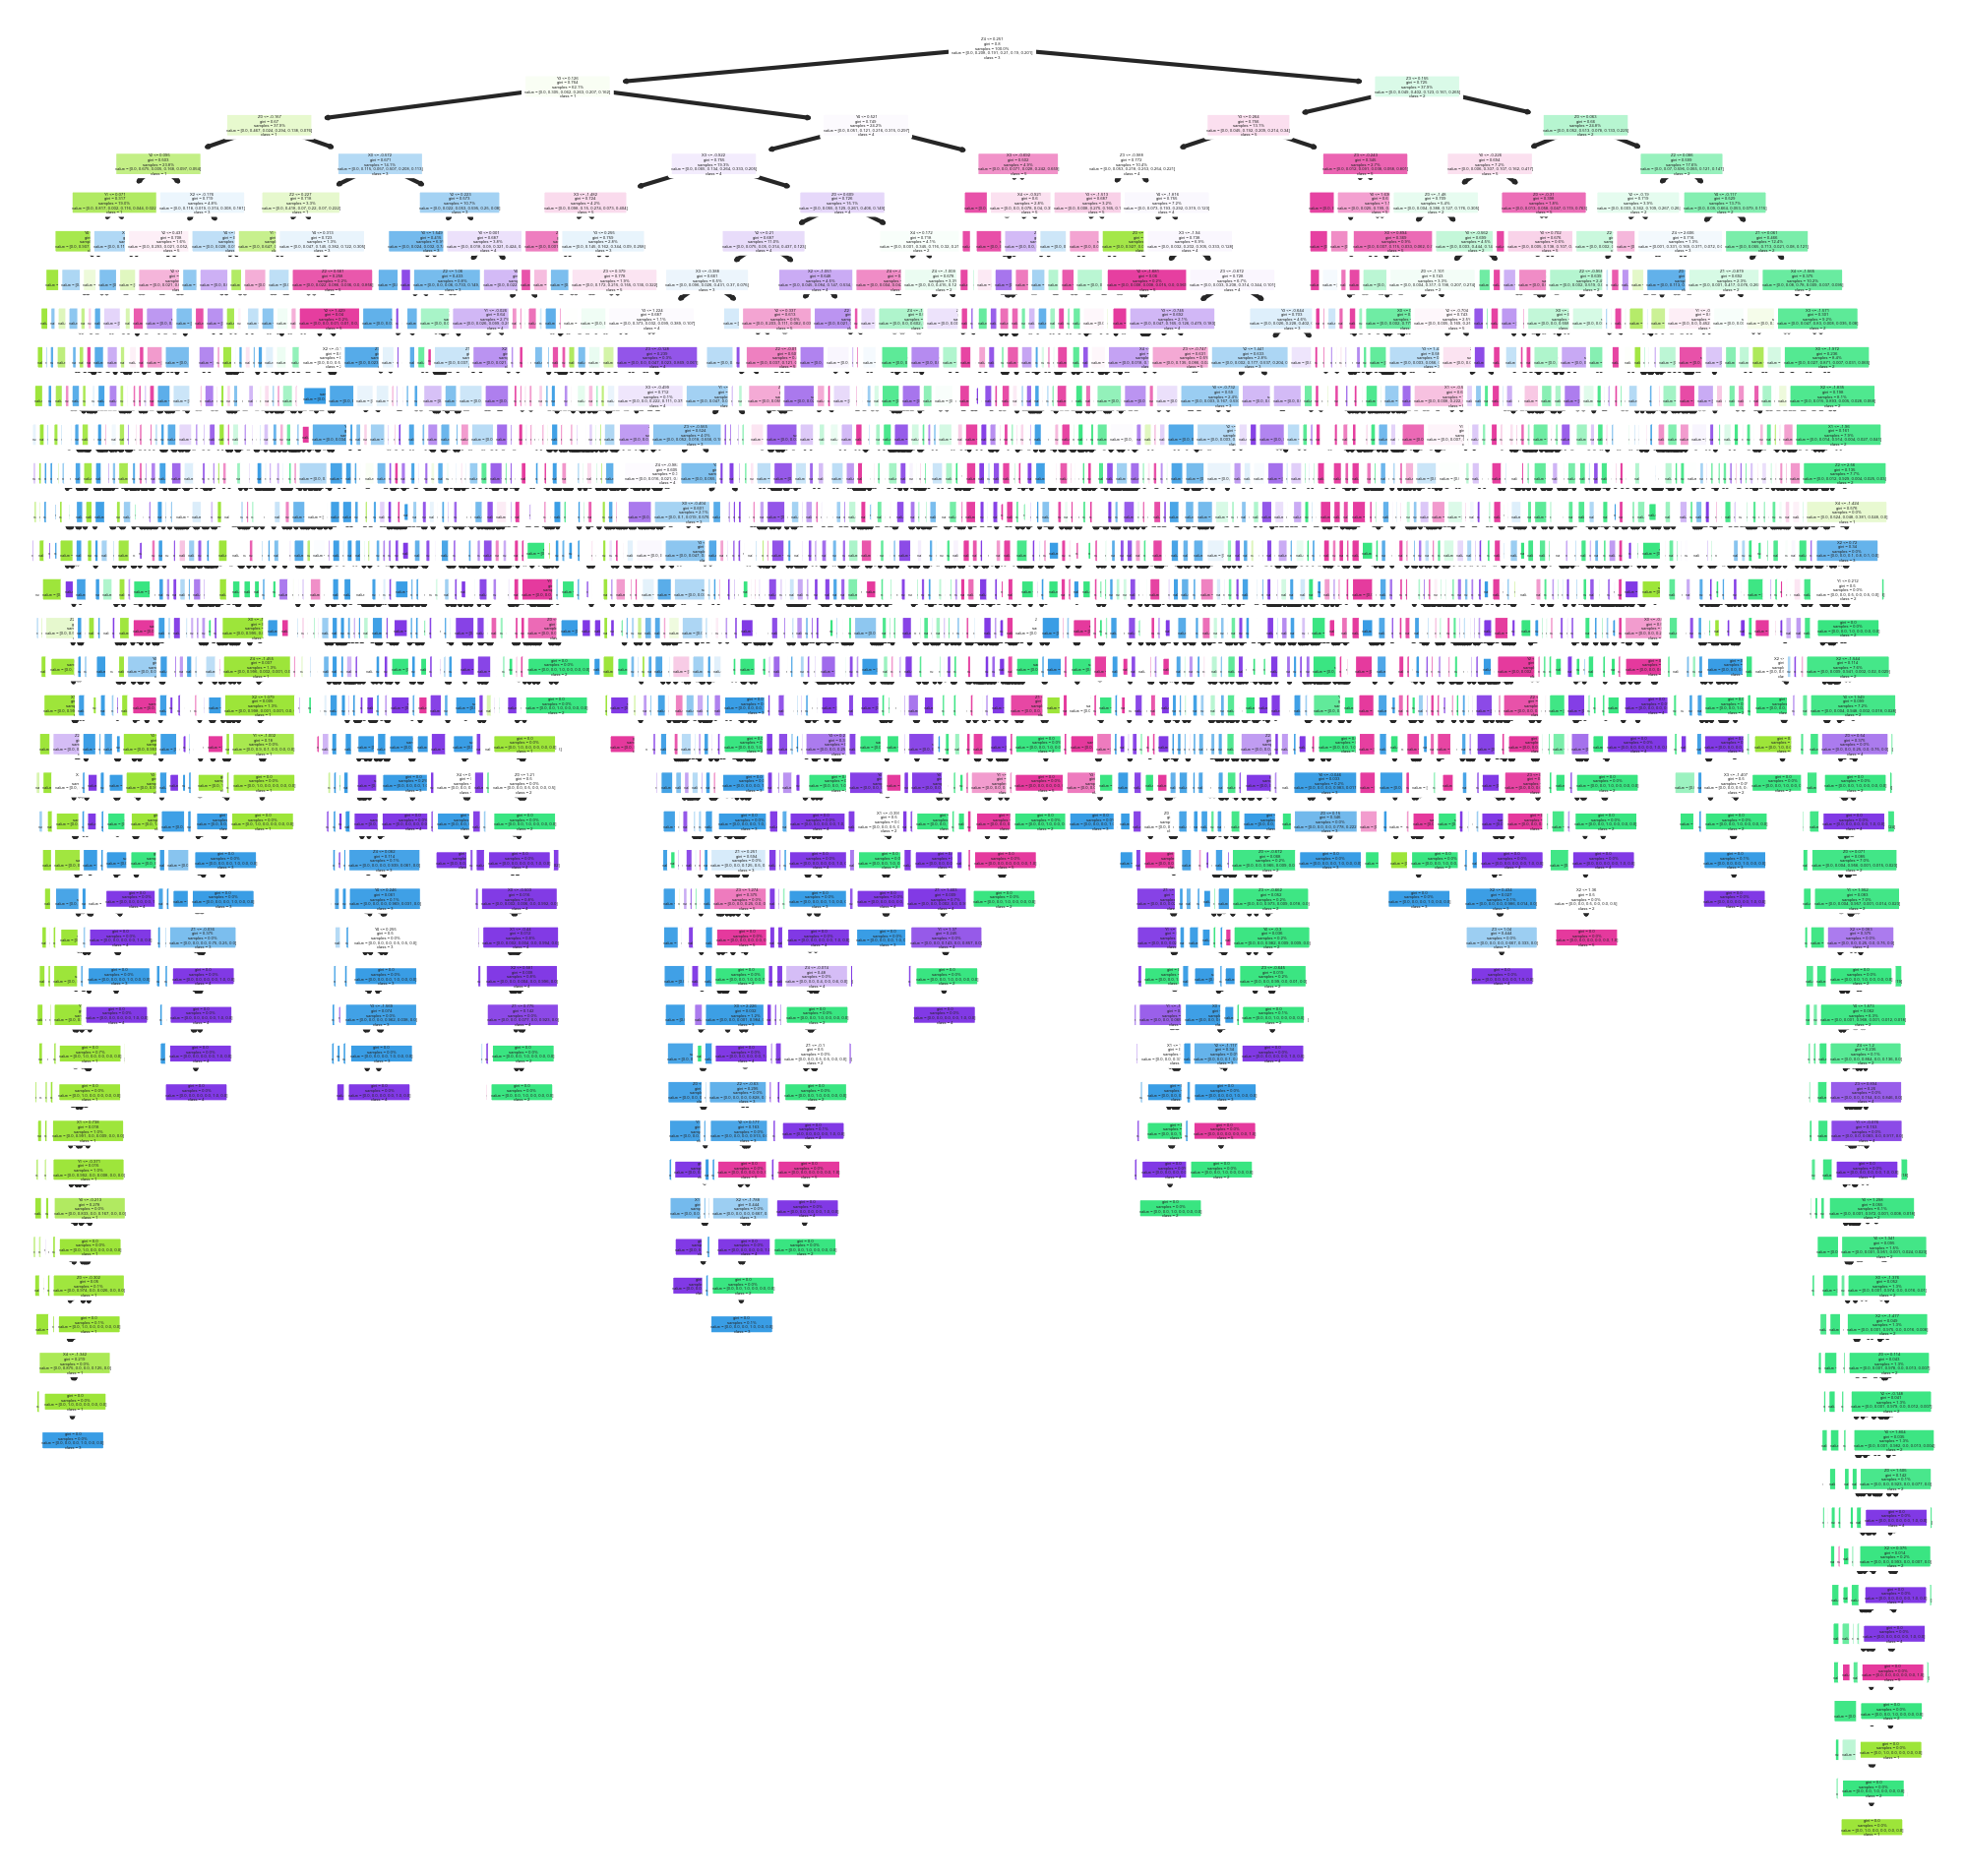

In [102]:
from sklearn import tree
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows = 1,ncols = 1,figsize = (8,8), dpi=300)

tree.plot_tree(decision_tree_model, ax= ax, feature_names = X_train.columns,
               class_names=["0","1","2","3","4","5"], filled = True,
               proportion = True, rounded=True)
plt.show()

## K-Nearest Neighbor
It is a lazy learning algorithm that stores all instances corresponding to training data in n-dimensional space, and it does not focus on constructing a general internal model, instead, it works on storing instances of training data. Also, it is a non-linear algorithm.

In [41]:
for i in range(1,15,2):
    knn_classifier = KNeighborsClassifier(n_neighbors = i,weights ="distance")
    knn_classifier.fit(X_train, y_train)
    knn_classifier_predictions = knn_classifier.predict(X_test)
    accuracy = accuracy_score(y_test,knn_classifier_predictions)
    print("K: ",i,"Accuracy: ",accuracy)

K:  1 Accuracy:  0.9270166453265045
K:  3 Accuracy:  0.9211267605633803
K:  5 Accuracy:  0.9156209987195902
K:  7 Accuracy:  0.9099871959026888
K:  9 Accuracy:  0.9051216389244559
K:  11 Accuracy:  0.900640204865557
K:  13 Accuracy:  0.8960947503201024


The k parameter is a very important parameter for the knn algorithm. We can observe the change of accuracy for different k values. Accordingly, it is seen that the accuracy decreases as the k value increases for this dataset.

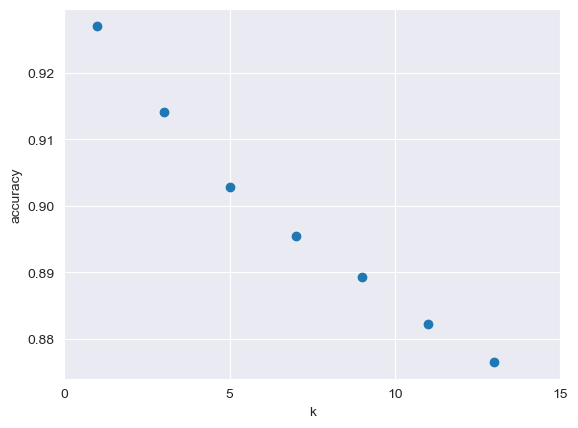

In [42]:
k_range = range(1, 15,2)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    scores.append(knn.score(X_test, y_test))
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,15])
plt.show()

In [78]:
knn_model = KNeighborsClassifier(n_neighbors=3).fit(X_train, y_train)
knn_predictions = knn_model.predict(X_test)
print('Accuracy of KNN classifier on training set: {:.2f}'
      .format(knn_model.score(X_train, y_train)))
print('Accuracy of KNN classifier on test set: {:.2f}'
      .format(knn_model.score(X_test, y_test)))

Accuracy of KNN classifier on training set: 0.95
Accuracy of KNN classifier on test set: 0.91


In [79]:
print(classification_report(y_test,knn_predictions))

              precision    recall  f1-score   support

           1       0.97      1.00      0.98      3250
           2       0.88      0.87      0.87      3056
           3       0.89      0.95      0.91      3206
           4       0.88      0.88      0.88      2935
           5       0.96      0.88      0.92      3173

    accuracy                           0.91     15620
   macro avg       0.91      0.91      0.91     15620
weighted avg       0.91      0.91      0.91     15620



In [82]:
print(confusion_matrix(y_test,knn_predictions))

[[3237    7    6    0    0]
 [  20 2649   76  220   91]
 [  40   45 3030   81   10]
 [  12  101  240 2573    9]
 [  29  225   70   59 2790]]


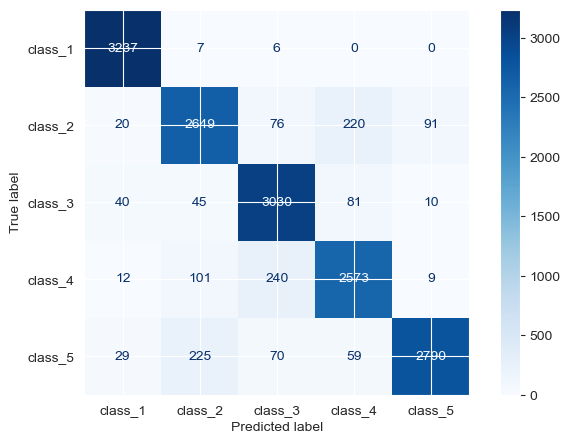

In [100]:
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(confusion_matrix(y_test, knn_predictions),display_labels=["class_1", "class_2", "class_3","class_4","class_5"])
cmp.plot(ax=ax,cmap=plt.cm.Blues)
plt.show()

## Comparing Performance of Algorithms

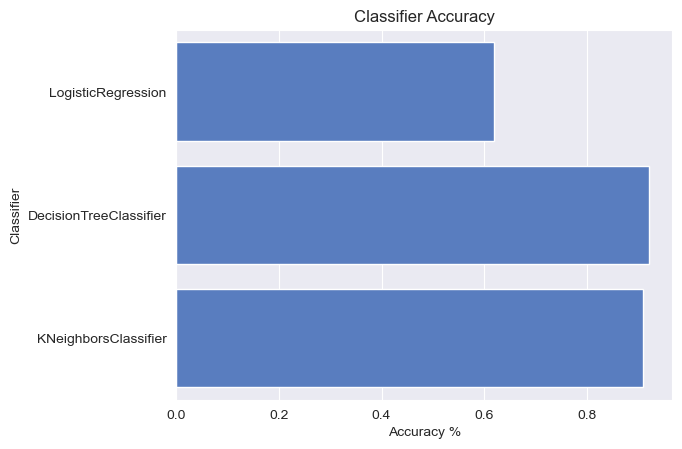

In [96]:
data = [['LogisticRegression',0.62],['DecisionTreeClassifier',0.92],['KNeighborsClassifier',0.91]]
accuracy_val = pd.DataFrame(data, columns=['Classifier','Accuracy'])
accuracies = pd.DataFrame(columns=accuracy_val)

sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=accuracy_val, color="b")

plt.xlabel('Accuracy %')
plt.title('Classifier Accuracy')
plt.show()

In [98]:
train_error=[0.62,1.0,0.95]
test_error=[0.62,0.92,0.91]

col={'Train Error':train_error,'Test Error':test_error}
models=['LogisticRegression','Decision Tree','Knn']
df_models = pd.DataFrame(data=col,index=models)
df_models

Train Error  Test Error
LogisticRegression         0.62        0.62
Decision Tree              1.00        0.92
Knn                        0.95        0.91

<AxesSubplot: >

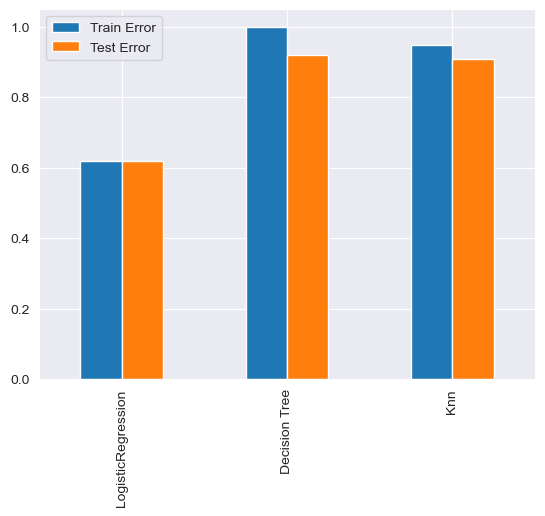

In [99]:
df_models.plot(kind='bar')

# Conclusion

Throughout this assignment, the focus was on classification, a supervised learning method. In classification, the model is fully trained using the training data, and then it is evaluated on test data before being used to perform prediction on new unseen data. Before creating models with 3 different classification algorithms, necessary preprocessing processes such as handling missing values and outliers were completed. The assignment was made more understandable with visualization techniques by using tables and graphics in the dataset comprehension and preprocessing stages. Then, 3 different models were created with LogisticRegression, DecisionTree and KNN algorithms and the results were observed. Since LogisticRegression is a linear classification algorithm, this dataset could not give good results like the others. From here it is understood that the dataset is not linearly seperable. DecisionTree and KNN algorithms gave close results. Since the k parameter, which is the most important parameter of the KNN algorithm, will be more optimal after trying with different values, the classification report and final accuracy values were obtained with the final model by choosing the value of 3. DecisionTree's train accuracy value of 100% showed us that the parameters should be set correctly in case of overfitting. It has been observed that the training time is longer because the Decision tree is a eager learning algorithm, and the testing time is longer because KNN is a lazy learning algorithm. The results of all models were also visualized and analyzed.